In [8]:
# IMPORTS
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playercareerstats, playergamelog, teamgamelog, leaguegamefinder, leaguegamelog, playerprofilev2, commonplayerinfo
from nba_api.live.nba.endpoints import scoreboard, playbyplay, boxscore
from nba_api.stats.library.parameters import SeasonAll
from datetime import datetime, timezone
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [9]:
# Specify the player name you're interested in
target_player_name = input("Enter the player name: ")

# Specify the team name you're interested in analyzing
opp_team_name = input("Enter the team to predict against: ")

Enter the player name:  James Harden
Enter the team to predict against:  SAC


In [13]:
# Find Players ID ---------------------------------------------------------------------------------------------------
nba_players = players.get_players() # Get the list of all NBA players
player_id = next((x for x in players.get_players() if x.get("full_name") == target_player_name), None).get("id")
#--------------------------------------------------------------------------------------------------------------------


# Get players team abbreviation -------------------------------------------------------------------------------------
player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id) # Get common player info for the specified player_id
player_info_data = player_info.get_data_frames()[0]
# Extract the team abbreviation from the player details
team_abbreviation = player_info_data['TEAM_ABBREVIATION'].values[0]
#--------------------------------------------------------------------------------------------------------------------


# Get the player's game log -----------------------------------------------------------------------------------------
gamelog = pd.concat(playergamelog.PlayerGameLog(player_id=player_id, season=SeasonAll.all).get_data_frames())
gamelog["GAME_DATE"] = pd.to_datetime(gamelog["GAME_DATE"], format="%b %d, %Y")
#--------------------------------------------------------------------------------------------------------------------


# Define a function to check if the game is against the specific team -----------------------------------------------
def is_specific_team(matchup):
    return 0 if opp_team_name in matchup else 1
#--------------------------------------------------------------------------------------------------------------------


# Initialize game finder --------------------------------------------------------------------------------------------
gamefinder = leaguegamefinder.LeagueGameFinder()
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
#--------------------------------------------------------------------------------------------------------------------


# Determine if the target players game today is home or away --------------------------------------------------------
board = scoreboard.ScoreBoard() # Get the scoreboard for today's games
games_data = board.games.get_dict()
# Create a list to store game information
game_list = []
# Format the game information and append it to the list
for game in games_data:
    gameTimeLTZ = parser.parse(game["gameTimeUTC"]).replace(tzinfo=timezone.utc).astimezone(tz=None)
    game_info = {
        "GameId": game['gameId'],
        "AwayTeam": game['awayTeam']['teamTricode'],
        "HomeTeam": game['homeTeam']['teamTricode'],
        "GameTimeLTZ": gameTimeLTZ
    }
    game_list.append(game_info)
# Convert the list of dictionaries to a DataFrame
games_df = pd.DataFrame(game_list)
def is_team_home_or_away(team_abbreviation, game_row):
    # Check if the team abbreviation is in the 'HomeTeam' column
    if team_abbreviation == game_row['HomeTeam']:
        return True
    # Check if the team abbreviation is in the 'AwayTeam' column
    elif team_abbreviation == game_row['AwayTeam']:
        return False
    # If the team abbreviation is not found in either column
    else:
        return None
for index, game_row in games_df.iterrows():
    is_home = is_team_home_or_away(team_abbreviation, game_row)
    if is_home is not None:
        print(f'Home game: {is_home}')
#--------------------------------------------------------------------------------------------------------------------


# Add additional columns to df --------------------------------------------------------------------------------------
gamelog['PLAYER_NAME'] = target_player_name  # Add a column for the player's name 
# Create a new column for home = 0 or away = 1
gamelog['HOME_AWAY'] = gamelog['MATCHUP'].apply(lambda x: 1 if '@' in x else 0)
# Apply the function to create the new column
gamelog['VERSUS_SPECIFIC_TEAM'] = gamelog['MATCHUP'].apply(is_specific_team)
# Create a new column for opposing_team_pts
gamelog['opposing_team_pts'] = 0  # Initialize the column
#--------------------------------------------------------------------------------------------------------------------


# Iterate through each row and populate the opposing_team_pts column ------------------------------------------------
for index, row in gamelog.iterrows():
    target_game_id = row['Game_ID']

    # Find the specific game based on Game_ID
    target_game = games[games['GAME_ID'] == target_game_id]

    # Check if the 'PTS' column is present
    if 'PTS' in target_game.columns:
        # Extract the 'PTS' value for the specified game and team
        opposing_team_pts = target_game.loc[target_game['TEAM_ABBREVIATION'] != team_abbreviation, 'PTS'].values
        if len(opposing_team_pts) > 0:
            gamelog.at[index, 'opposing_team_pts'] = opposing_team_pts[0]
#--------------------------------------------------------------------------------------------------------------------


# Display the updated DataFrame
gamelog = gamelog[['PLAYER_NAME', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'MIN','PTS', 'FGM', 'FGA', 'FG_PCT', 'FTM', 'FTA', 'FT_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'REB', 'PLUS_MINUS', 'HOME_AWAY', 'VERSUS_SPECIFIC_TEAM', 'opposing_team_pts']]
print(team_abbreviation)
gamelog

Home game: False
LAC


,PLAYER_NAME,Game_ID,GAME_DATE,MATCHUP,MIN,PTS,FGM,FGA,FG_PCT,FTM,FTA,FT_PCT,FG3M,FG3A,FG3_PCT,REB,PLUS_MINUS,HOME_AWAY,VERSUS_SPECIFIC_TEAM,opposing_team_pts
0,James Harden,0022300257,2023-11-27,LAC vs. DEN,36,11,3,7,0.429,2,2,1.000,3,5,0.600,2,6,0,1,113
1,James Harden,0022300244,2023-11-25,LAC vs. DAL,28,8,2,8,0.250,2,2,1.000,2,6,0.333,4,14,0,1,88
2,James Harden,0022300052,2023-11-24,LAC vs. NOP,37,8,2,8,0.250,3,6,0.500,1,6,0.167,5,-6,0,1,116
3,James Harden,0022300235,2023-11-22,LAC @ SAS,36,16,3,7,0.429,8,12,0.667,2,4,0.500,6,-2,1,1,102
4,James Harden,0022300223,2023-11-20,LAC @ SAS,28,13,4,12,0.333,3,3,1.000,2,8,0.250,3,17,1,1,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,James Harden,0020900081,2009-11-06,OKC @ HOU,10,4,2,3,0.667,0,0,0.000,0,0,0.000,1,-8,1,1,0
1007,James Harden,0020900057,2009-11-03,OKC vs. LAL,17,9,3,9,0.333,2,2,1.000,1,2,0.500,1,16,0,1,0
1008,James Harden,0020900042,2009-11-01,OKC vs. POR,18,6,2,9,0.222,0,0,0.000,2,3,0.667,3,4,0,1,0
1009,James Harden,0020900023,2009-10-30,OKC @ DET,17,2,1,6,0.167,0,0,0.000,0,1,0.000,2,17,1,1,0


In [14]:
# Calculate total career points and total games played
total_career_points = gamelog['PTS'].sum()
total_career_games = len(gamelog)

# Calculate career average points per game (PPG)
career_avg_ppg = total_career_points / total_career_games

# Display the result
print(f"{target_player_name}'s Career Average PPG: {career_avg_ppg}")

James Harden's Career Average PPG: 24.577645895153314


In [15]:
# LINEAR MODEL

# Extract the relevant columns for your features and target
selected_features = ['PTS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FTM', 'FTA', 'FT_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'REB', 'PLUS_MINUS', 'HOME_AWAY', 'VERSUS_SPECIFIC_TEAM', 'opposing_team_pts']
gamelog_selected = gamelog[selected_features]
gamelog_selected['recent_games_weight'] = 1.0 

# Create X_train and y_train
y_train = gamelog_selected['PTS']
X_train = gamelog_selected.drop('PTS', axis=1)
#y_train = gamelog_selected['PTS'][:10]
#X_train = gamelog_selected.drop('PTS', axis=1)[10:]  #train data from 10th row on, test data on top 10 rows (:10)

# Add more weight to home games and games vs the opp
if is_home:
    X_train['home_weight'] = X_train['HOME_AWAY'].apply(lambda x: 1.0 if x == 0 else 0.7)
else:
    X_train['away_weight'] = X_train['HOME_AWAY'].apply(lambda x: 1.0 if x == 1 else 0.7)

X_train['vs_opp_weight'] = X_train['VERSUS_SPECIFIC_TEAM'].apply(lambda x: 1.5 if x == 0 else 0.7)

# Drop the original 'home' and 'opponent' columns
X_train = X_train.drop(['HOME_AWAY', 'VERSUS_SPECIFIC_TEAM'], axis=1)

# Add more weight to the top 10 rows
X_train['recent_games_weight'] = 0.70  # or any other weight you want to assign to the top rows
X_train['recent_games_weight'].iloc[:10] = 1.0  # Adjust the weight for the top 10 rows


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                                                   
# Create and train the model
model = RandomForestRegressor()
#model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared Value: {r_squared}') #R-squared value provides an indication of how much variance in the target variable is explained by your model, with 1.0 being a perfect fit.

target_range = gamelog['PTS'].max() - gamelog['PTS'].min()
print(f'Target range: {target_range}')

# Drop non-numeric columns from gamelog
gamelog_numeric = gamelog_selected.select_dtypes(include=['float64', 'int64'])

if is_home:
    gameat = 'home'
else:
    gameat = 'away'

# Use the trained model to predict the points for tonight's game
predicted_points = model.predict(gamelog_numeric.drop('PTS', axis=1).values)
print(f'{target_player_name} is playing {gameat} vs {opp_team_name} and is predicted to score approximately {predicted_points[0]:.2f} points tonight.')

# Predicted points keep reflecting amount of points based off the players last game... not ideal
# Figure out how to train the data on older games and use recent games for testing

C:\Users\fishm\AppData\Local\Temp\ipykernel_17508\1007077141.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamelog_selected['recent_games_weight'] = 1.0
C:\Users\fishm\AppData\Local\Temp\ipykernel_17508\1007077141.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['recent_games_weight'].iloc[:10] = 1.0  # Adjust the weight for the top 10 rows


Mean Squared Error: 1.0199014778325122
R-squared Value: 0.9915482559844145
Target range: 61
James Harden is playing away vs SAC and is predicted to score approximately 10.46 points tonight.


C:\Users\fishm\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [38]:
# LINEAR MODEL
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler


# Extract the relevant columns for your features and target
selected_features = ['PTS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FTM', 'FTA', 'FT_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'REB', 'PLUS_MINUS', 'HOME_AWAY', 'VERSUS_SPECIFIC_TEAM', 'opposing_team_pts']
gamelog_selected = gamelog[selected_features]
gamelog_selected['recent_games_weight'] = 1.0

# Shuffle the data before splitting
gamelog_selected = shuffle(gamelog_selected, random_state=42)

# Create X_train and y_train
y_train = gamelog_selected['PTS']
X_train = gamelog_selected.drop('PTS', axis=1)

# Add more weight to home games and games vs the opp
if is_home:
    X_train['home_weight'] = X_train['HOME_AWAY'].apply(lambda x: 1.0 if x == 0 else 0.7)
else:
    X_train['away_weight'] = X_train['HOME_AWAY'].apply(lambda x: 1.0 if x == 1 else 0.7)

X_train['vs_opp_weight'] = X_train['VERSUS_SPECIFIC_TEAM'].apply(lambda x: 1.5 if x == 0 else 0.7)

# Drop the original 'home' and 'opponent' columns
X_train = X_train.drop(['HOME_AWAY', 'VERSUS_SPECIFIC_TEAM'], axis=1)

# Add more weight to the top 10 rows
X_train['recent_games_weight'] = 0.70  # or any other weight you want to assign to the top rows
X_train['recent_games_weight'].iloc[:10] = 1.0  # Adjust the weight for the top 10 rows

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared Value: {r_squared}')

target_range = gamelog['PTS'].max() - gamelog['PTS'].min()
print(f'Target range: {target_range}')

# Drop non-numeric columns from gamelog
gamelog_numeric = gamelog_selected.select_dtypes(include=['float64', 'int64'])

if is_home:
    gameat = 'home'
else:
    gameat = 'away'

# Use the trained model to predict the points for tonight's game
predicted_points = model.predict(gamelog_numeric.drop('PTS', axis=1).values)
print(f'{target_player_name} is playing {gameat} vs {opp_team_name} and is predicted to score approximately {predicted_points[0]:.2f} points tonight.')


C:\Users\fishm\AppData\Local\Temp\ipykernel_15240\4108212996.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamelog_selected['recent_games_weight'] = 1.0
C:\Users\fishm\AppData\Local\Temp\ipykernel_15240\4108212996.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['recent_games_weight'].iloc[:10] = 1.0  # Adjust the weight for the top 10 rows


Mean Squared Error: 2.299955555555556
R-squared Value: 0.9713693589699806
Target range: 44
De'Aaron Fox is playing home vs GSW and is predicted to score approximately 42.03 points tonight.


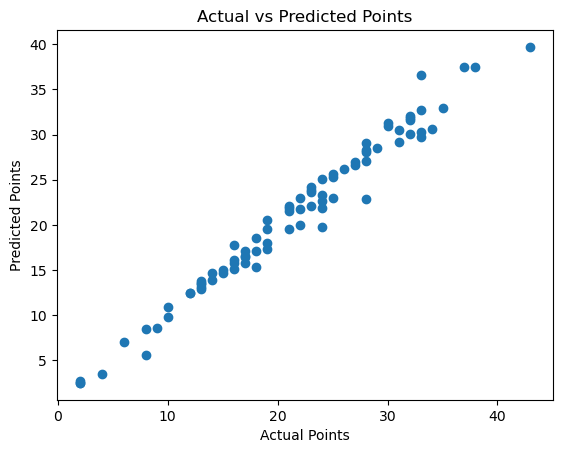

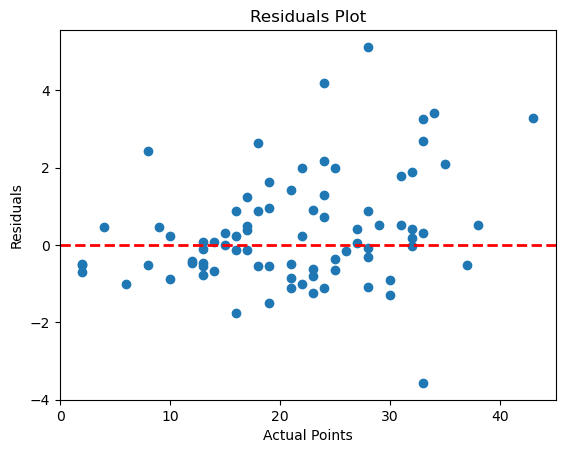

In [35]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()

# Visualize residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Points')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals Plot')
plt.show()

In [180]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df

,Actual,Predicted
156,16,16.0
145,21,21.0
101,18,18.0
127,5,5.0
141,30,30.0
139,7,7.0
42,23,23.0
15,32,32.0
126,18,18.0
65,24,24.0
